### 🖋 **Notebook Contents**

0. Initial Setup
1. Data Understanding
2. Data Preparation
3. Modelling

****

## `Initial Setup`

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# ignore warning
import warnings
warnings.filterwarnings("ignore")

## `Data Understanding`

Dataset dapat di akses pada link berikut: [dataset](https://github.com/Divyanshu-ISM/Machine-Learning-Deep-Learning/blob/main/PhiK.csv)!

| Columns                                            | Definition                                                   | 
| ------------------------------------------------- | ------------------------------------------------------------ |
| `Porosity` | ratio of the volume of pores to the volume of bulk rock (fraction)/kemampuan batuan untuk menyimpan fluida |
| `Swc` | connate water saturation is the minimum water saturation which would remain adhered to the pores and not become mobile |
| `Permeability(D)` | measure of the connectivity of pores in the subsurface (Darcy)/kemampuan batuan untuk mengalirkan fluida |

In [4]:
# load dataset
df = pd.read_csv('../data/PhiK.csv', index_col=0)
df.sample(10)

,Porosity,Swc,Permeability(D)
17669,0.227905,0.102110,1.228901
6957,0.361352,0.092669,11.338652
62461,0.183449,0.100389,0.489370
19385,0.264435,0.103931,2.281672
62244,0.292072,0.088014,4.927055
50276,0.280568,0.095418,3.512784
21855,0.225100,0.095592,1.327842
55100,0.239992,0.104690,1.467543
28202,0.208760,0.108832,0.735316
46835,0.234839,0.100122,1.458371


In [5]:
# jumlah baris dan kolom
print(f'Jumlah baris dan kolom: {df.shape[0]} baris dan {df.shape[1]} kolom')

# cek duplikat
print(f"Jumlah data duplikat : \x1b[31m{df[df.duplicated()].shape[0]} baris\x1b[0m")

# quality of DataFrame
pd.DataFrame(
                {
                'columns': df.columns.values,
                'data_type': df.dtypes.values,
                'null_value(%)': df.isna().mean().values * 100,
                'n_unique': df.nunique().values,
                'zero_value' : [True if (df[col] == 0).any() else False for col in df.columns],
                'neg_value' : [True if (df[col].dtype == int or df[col].dtype == float) and (df[col] < 0).any() else False for col in df.columns],
                'min': df.min().values,
                'max': df.max().values,
                'sample_unique': [df[col].unique() for col in df.columns]
                }
            )

Jumlah baris dan kolom: 70000 baris dan 3 kolom
Jumlah data duplikat : 0 baris


,columns,data_type,null_value(%),n_unique,zero_value,neg_value,min,max,sample_unique
0,Porosity,float64,0.0,70000,False,False,0.042789,0.478269,"[0.2691582335902463, 0.3242748946626044, 0.218..."
1,Swc,float64,0.0,70000,False,False,0.054212,0.141312,"[0.1142094893993757, 0.0720779601473649, 0.101..."
2,Permeability(D),float64,0.0,70000,False,False,0.000679,38.662256,"[2.0425292290268784, 11.639989217647468, 1.015..."


Insight:
- dataset terdiri dari 70000 baris dan 3 kolom
- tipe data sudah sesuai
- tidak ada duplikat data
- tidak ada missing values
- tidak ada negative values
- tidak ada categorical columns

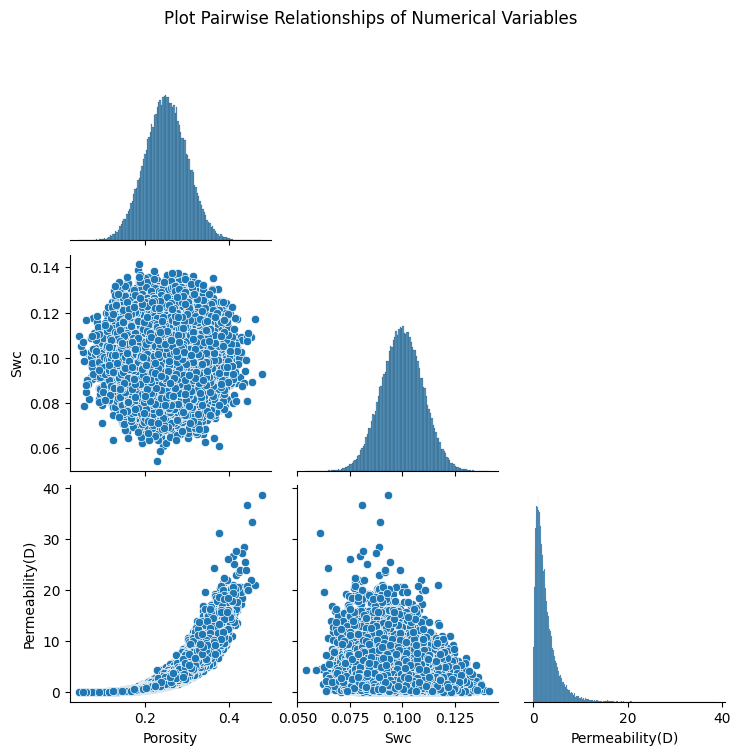

In [6]:
grph = sns.pairplot(df, corner=True, diag_kind='hist')
grph.fig.suptitle("Plot Pairwise Relationships of Numerical Variables", y=1)
plt.show()

Insight:
- kolom permeabilitas (target) termasuk **skewed kanan**
- hubungan antar variabel **tidak linear**
- Swc dan Porosity memiliki **disitribusi normal**
- Permeabilitiy(D) mimiliki **distribusi tidak normal**
- Pada kolom porosity dan permeability & Swc dan permeability terdapat bivariate outlier
- Cek korelasi menggunakan metode Spearman karena distribusi data bersifat tidak linear

### 1️⃣ Outlier Detection

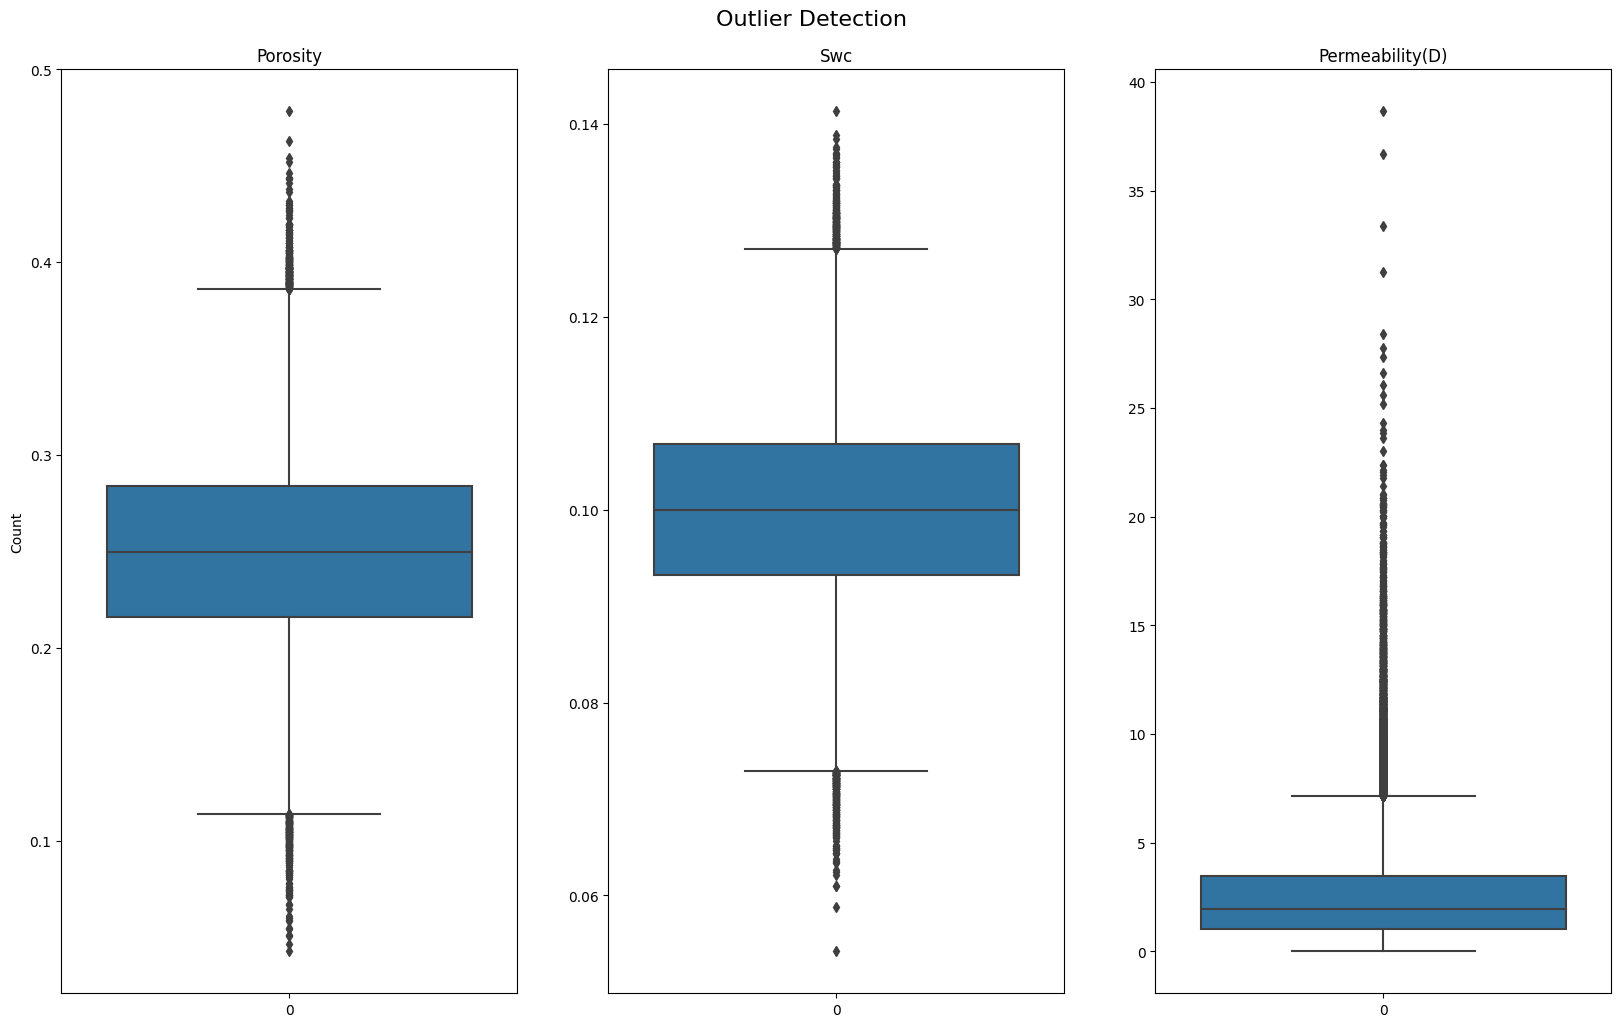

In [7]:
def boxlots_custom(dataset, columns_list, rows, cols, suptitle,size=(20,16)):
    """Function to make histogram plot of all of columns. 

    Args:
        dataset : DataFrame
        columns_list (string) : columns
        rows : number of rows of axes
        cols : number of cols of axes
        suptitle : title of the plots
        size : size of canvas

    Return:
        histogram plot

    """

    fig, axs = plt.subplots(rows, cols,  figsize=size)
    fig.suptitle(suptitle,y=0.93, size=16)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        if i % cols == 0:
            axs[i].set_ylabel('Count')
        sns.boxplot(data=dataset[data], orient='v', ax=axs[i])
        axs[i].set_title(data)

boxlots_custom(df, df.columns, 1, 3, suptitle='Outlier Detection', size=(20,12))

### 2️⃣ Heatmap Correlation

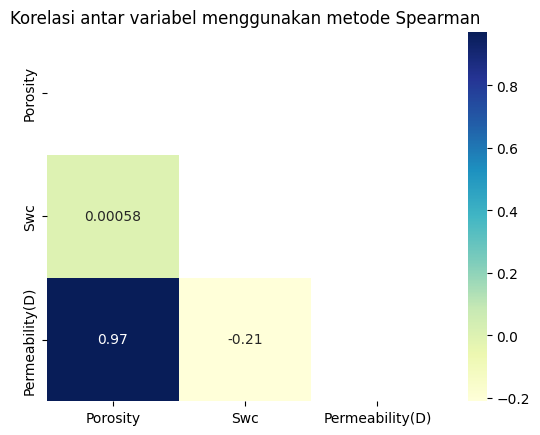

In [8]:
# menggunakan korelasi Spearman
mask = np.triu(np.ones_like(df.corr('spearman')))

# plot the heatmap correlation
plt.title("Korelasi antar variabel menggunakan metode Spearman", loc='center')
sns.heatmap(df.corr('spearman'), cmap='YlGnBu', annot=True, mask=mask)
plt.show()

insight:
- Kolom porosity dan permeability memiliki nilai korelasi tinggi, yaitu sebesar **0.97**
- Kolom Swc dan permeability memiliki nilai korelasi rendah dan negatif, sebesar **-0.21**
- Kolom Porosity dan Swc memiliki nilai korelasi yang rendah. Hal ini menunjukkan **tidak ada multicolinearity** pada kolom tersebut.

## `Data Preparation`

<h3><span style="color:#0ad0f7">Cek dan handling missing values</span></h3>

Porosity           0
Swc                0
Permeability(D)    0
dtype: int64

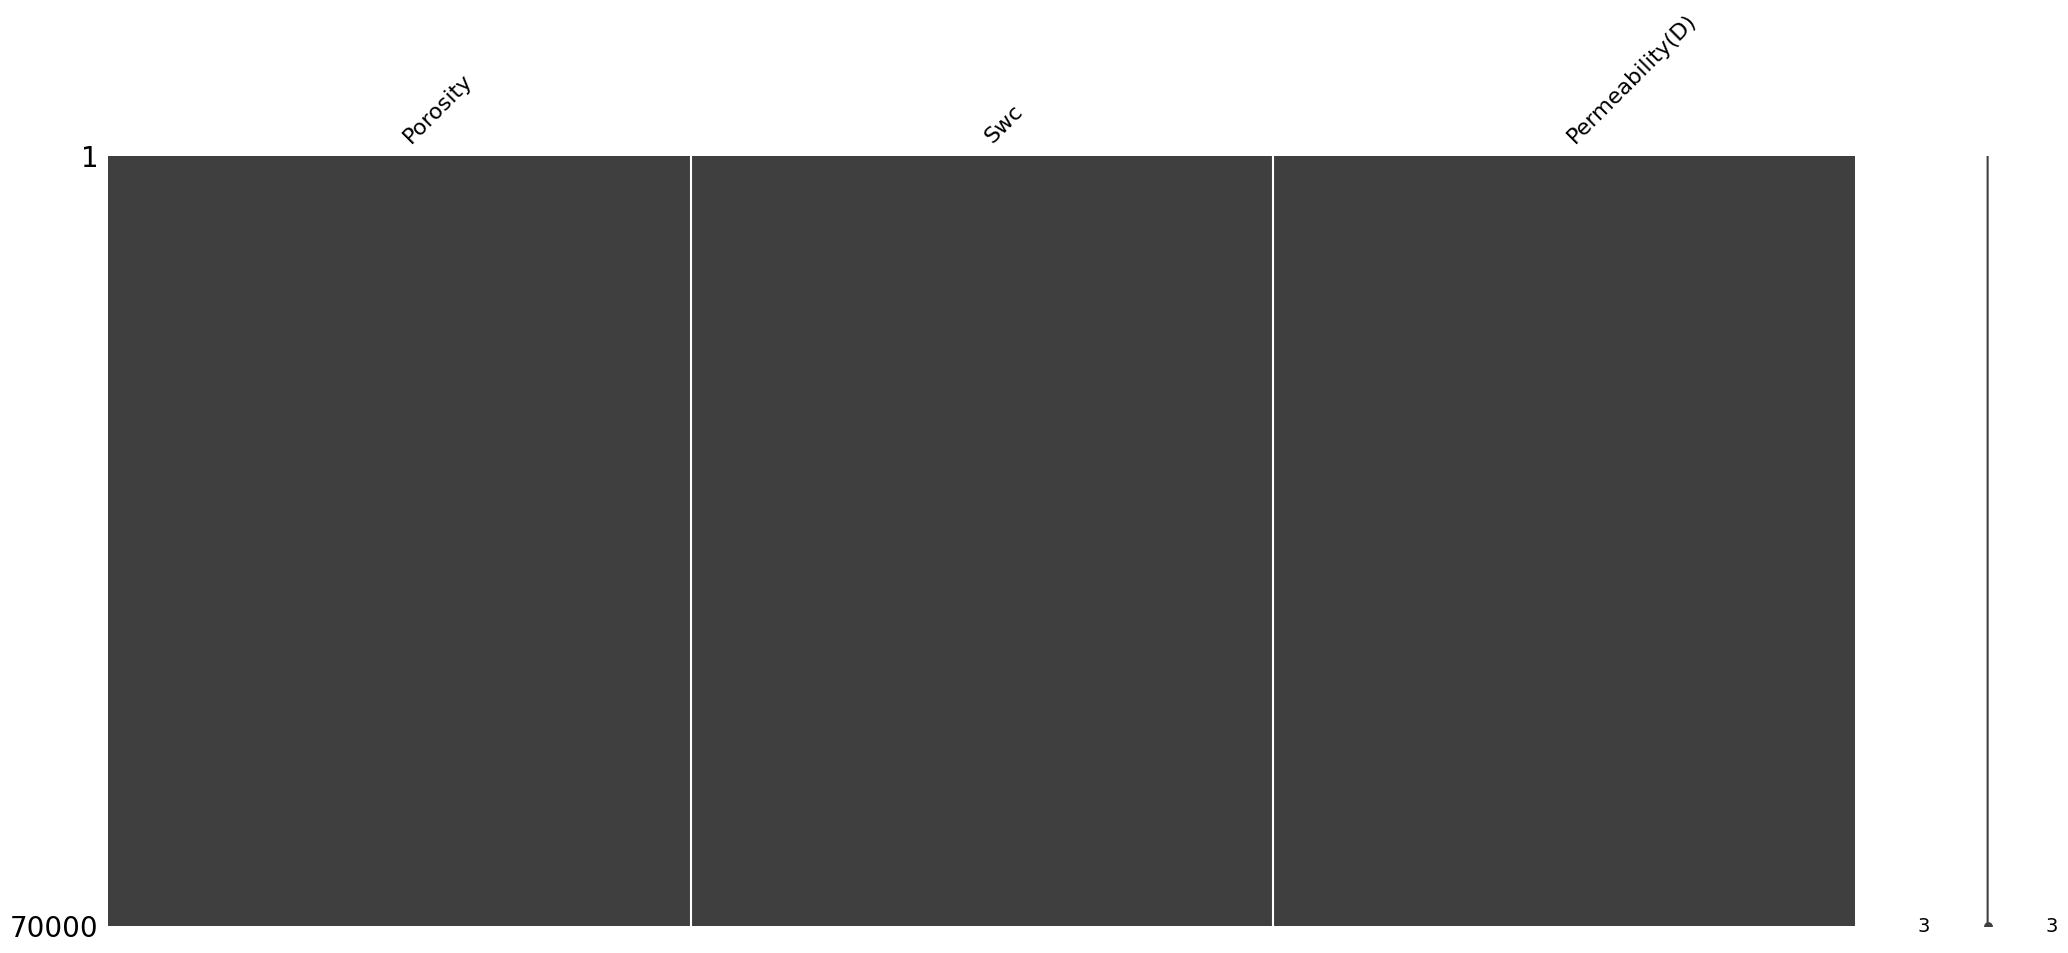

In [9]:
import missingno as msno
msno.matrix(df)
df.isna().sum()

<h3><span style="color:#0ad0f7">Cek dan handling duplikat data</span></h3>

In [10]:
display(df.loc[df.duplicated()])

if df.loc[df.duplicated()].shape[0] == 0:
    print("Tidak ada duplikat data")
else:
    print(f"Terdapat duplikat data sebanyak {df.loc[df.duplicated()].shape[0]} baris")

,Porosity,Swc,Permeability(D)


Tidak ada duplikat data


## `Modelling`

In [5]:
# model algorithm
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline

# data preparation
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, KFold
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error, r2_score

# function to calculate adjusted R2
def adj_r2(val, rowCount, featureCount):
    return 1 - (1-val)*(rowCount-1)/(rowCount-featureCount-1)

import statistics as stats

In [6]:
# split train dan test
dfTrain, dfTest = train_test_split(df, test_size=0.2, random_state=22)

target = 'Permeability(D)'
feature = df.drop(columns='Permeability(D)').columns

display(dfTrain.shape, dfTest.shape)

(56000, 3)

(14000, 3)

<h3><span style="color:#0ad0f7">Benchmark Model</span></h3>

In [7]:
# Create Model
RANDOM_STATE = 22

# Model without transformed target
# Stand Alone Model
lr = LinearRegression()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor(random_state=RANDOM_STATE)

# Ensemble Model
rf = RandomForestRegressor(random_state=RANDOM_STATE)
xgb = XGBRegressor(random_state=RANDOM_STATE)
ada = AdaBoostRegressor(random_state=RANDOM_STATE)
catboost = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)
lightgbm = LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbosity=0)

# Model with transformed target
# Stand Alone Model
log_lr = TransformedTargetRegressor(lr, func=np.log, inverse_func=np.exp)
log_knn = TransformedTargetRegressor(knn, func=np.log, inverse_func=np.exp)
log_dt = TransformedTargetRegressor(dt, func=np.log, inverse_func=np.exp)

# Ensemble Model
log_rf = TransformedTargetRegressor(rf, func=np.log, inverse_func=np.exp)
log_xgb = TransformedTargetRegressor(xgb, func=np.log, inverse_func=np.exp)
log_ada = TransformedTargetRegressor(ada, func=np.log, inverse_func=np.exp)
log_catboost = TransformedTargetRegressor(catboost, func=np.log, inverse_func=np.exp)
log_lightgbm = TransformedTargetRegressor(lightgbm, func=np.log, inverse_func=np.exp)

In [8]:
# collect model
models = {
    'LinearRegression': lr,
    'KNeighborsRegressor': knn,
    'DecisionTreeRegressor': dt,
    'RandomForestRegressor': rf,
    'XGBRegressor': xgb,
    'AdaBoostRegressor': ada,
    'CatBoostRegressor' : catboost,
    'LGBMRegressor' : lightgbm,
    'LinearRegression-logTarget': log_lr
    # 'KNeighborsRegressor-logTarget': log_knn,
    # 'DecisionTreeRegressor-logTarget': log_dt,
    # 'RandomForestRegressor-logTarget': log_rf,
    # 'XGBRegressor-logTarget': log_xgb,
    # 'AdaBoostRegressor-logTarget': log_ada,
    # 'CatBoostRegressor-logTarget' : log_catboost,
    # 'LGBMRegressor-logTarget' : log_lightgbm
    }

result1 = []

for name, est in models.items():
    
    crossval = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    estimator = Pipeline([
        ('scaller', RobustScaler()),
        ('model', est)
    ])

    # MAE, MAPE, and R2 cross-validation & fit time
    cv_result = cross_validate(
        estimator, 
        dfTrain[feature], 
        dfTrain[target], 
        cv=crossval, 
        scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'r2'],
        return_train_score=True,
        n_jobs=-1
        )
    
    # Fit time
    fit_time = cv_result['fit_time']
    
    # MAE
    train_mae = -cv_result['train_neg_mean_absolute_error']
    val_mae = -cv_result['test_neg_mean_absolute_error']

    # MAPE
    train_mape = -cv_result['train_neg_mean_absolute_percentage_error']
    val_mape = -cv_result['test_neg_mean_absolute_percentage_error']

    # R2
    train_r2 = cv_result['train_r2']
    val_r2 = cv_result['test_r2']

    # Adjusted R2
    res_train = []
    res_val = []
    for train in train_r2:
        res_train.append(adj_r2(train, len(dfTrain), len(feature)))
    for val in val_r2:
        res_val.append(adj_r2(val, len(dfTrain), len(feature)))

    # Collect Result
    result1.append(
        {
            'Model': name,
            # score
            'MAE_train': abs(train_mae.mean()),
            'MAE_val' : abs(val_mae.mean()),
            'MAPE_train': abs(train_mape.mean()),
            'MAPE_val' : abs(val_mape.mean()),
            'r2_train': train_r2.mean(),
            'r2_val' : val_r2.mean(),
            'Adjusted-r2_train':np.array(res_train).mean(),
            'Adjusted-r2_val':np.array(res_val).mean(),
            # standard deviation
            'std-MAE_train': stats.stdev(train_mae),
            'std-MAE_val': stats.stdev(val_mae),
            'std-MAPE_train': stats.stdev(train_mape),
            'std-MAPE_val' : stats.stdev(val_mape),
            'std-r2_train' : stats.stdev(train_r2),
            'std-r2_val' : stats.stdev(val_r2),
            'std-adjusted-r2_train' : stats.stdev(res_train),
            'std-adjusted-r2_val' : stats.stdev(res_val),
            # fit time
            'mean_fit_time' : fit_time.mean(),
            'std_fit_time' : stats.stdev(fit_time)

        }
    )

resultDf1 = pd.DataFrame(result1).set_index('Model')

printedTab1 = resultDf1.sort_values(by='MAPE_val')\
    .style\
    .highlight_max(subset=['r2_val','Adjusted-r2_val'], color = 'yellow', axis = 0)\
    .highlight_min(subset=['MAE_val','MAPE_val'], color = 'yellow', axis = 0)

# display table
printedTab1

,MAE_train,MAE_val,MAPE_train,MAPE_val,r2_train,r2_val,Adjusted-r2_train,Adjusted-r2_val,std-MAE_train,std-MAE_val,std-MAPE_train,std-MAPE_val,std-r2_train,std-r2_val,std-adjusted-r2_train,std-adjusted-r2_val,mean_fit_time,std_fit_time
Model,,,,,,,,,,,,,,,,,,
RandomForestRegressor,0.003659,0.009352,0.001179,0.002936,0.999798,0.998288,0.999797,0.998288,0.000066,0.001321,0.000016,0.000101,0.000059,0.002386,0.000059,0.002387,12.393576,0.124621
KNeighborsRegressor,0.012428,0.015707,0.005164,0.006466,0.998825,0.997577,0.998825,0.997577,0.000185,0.001571,0.000118,0.000574,0.000234,0.002549,0.000234,0.002549,0.027237,0.006836
DecisionTreeRegressor,0.000000,0.023017,0.000000,0.007863,1.000000,0.997585,1.000000,0.997585,0.000000,0.001025,0.000000,0.000111,0.000000,0.001941,0.000000,0.001941,0.154811,0.007030
XGBRegressor,0.023891,0.031157,0.014935,0.016901,0.999781,0.998026,0.999781,0.998026,0.000675,0.000906,0.000348,0.001426,0.000010,0.002364,0.000010,0.002364,3.710071,0.027093
CatBoostRegressor,0.029522,0.034407,0.019372,0.020161,0.996937,0.990732,0.996937,0.990732,0.001391,0.002356,0.001346,0.002632,0.000545,0.006203,0.000545,0.006204,9.265934,0.120542
LGBMRegressor,0.035300,0.038966,0.022411,0.023572,0.994329,0.991607,0.994329,0.991606,0.000611,0.002932,0.000959,0.003919,0.001065,0.006250,0.001065,0.006251,0.522910,0.084407
LinearRegression-logTarget,0.339115,0.339146,0.110547,0.110558,0.704847,0.706755,0.704836,0.706745,0.003192,0.016102,0.000694,0.002353,0.028826,0.116695,0.028827,0.116699,0.021654,0.008262
AdaBoostRegressor,0.681463,0.683377,1.168677,1.170917,0.881571,0.878168,0.881567,0.878164,0.043872,0.044798,0.085378,0.171114,0.012062,0.012545,0.012062,0.012546,1.375306,0.023915
LinearRegression,0.689262,0.689298,1.930579,1.931633,0.799552,0.799673,0.799545,0.799666,0.002955,0.007124,0.118609,0.499558,0.002144,0.008317,0.002144,0.008318,0.018238,0.009934


**_Insight_**:

From the table above, it can be seen that Random Forest is the best model when validating on the data stream. But, when we compared all metric evaluation (MAE, MAPE, R2, adjusted-R2, and fit time) together, we can say that XGB Regressor is the best model. Because, if we look at r2, adjusted-r2, and fit time (3 times faster), XGB Regressor is better than Random Forest. Random Forest also tends to overfit when we look at its MAE and MAPE score. In other hand, XGB Regressor is more robust when we look at its MAE and MAPE (slightly different), it's mean that XGB Regressor tends not to overfit. As a result, the base model to be used is **XGB Regressor** with **MAE at 0.031157, MAPE at 0.016901, R2 at 0.998026, and adjusted-R2 at 0.998026**.

**How Extreme Gradient Boost Works?**

Gradient boosting Regression calculates the difference between the current prediction and the known correct target value. This difference is called residual. After that Gradient boosting Regression trains a weak model that maps features to that residual. The high level steps that we follow to implement Gradient Boosting Regression is as below:

1. Select a weak learner
2. Use an additive model
3. Define a loss function
4. Minimize the loss function

Reference: [paperspace](https://blog.paperspace.com/implementing-gradient-boosting-regression-python/#:~:text=Gradient%20boosting%20Regression%20calculates%20the,maps%20features%20to%20that%20residual.)

<h3><span style="color:#0ad0f7">Hyperparameter Tuning: XGB Regressor</span></h3>

Next, we will try to tuning our base models, so we can improve our models.

In [15]:
# max_dept
max_depth = list(np.arange(1, 6))
# Learning rate
learning_rate = list(np.arange(1, 10)/100)
# number of estimator(tree)
n_estimators = list(np.arange(100, 600,100))

# # Hyperparam space XGboost
hyperparam_space_xgb = {
    'model__max_depth': max_depth, 
    'model__learning_rate': learning_rate,
    'model__n_estimators': n_estimators,
}

In the hyperparameter tuning we use 3 paramaters. This is intended to avoid overfitting and too long iteration time. Hyperparamter that we use are:

- **learning_rate** (float, optional): Learning rate for the gradient boosting algorithm. When a new tree ∇ft,i is trained, it will be added to the existing trees ft−1,i. Before doing so, it will be multiplied by the learning_rate. Decreasing this hyperparameter reduces the likelihood of overfitting. Range: [0, 1]
- **max_depth** (int, optional): Maximum allowed depth of the trees. Decreasing this hyperparameter reduces the likelihood of overfitting. Range: [0, ∞]
- **n_estimators** (int, optional): Number of estimators (trees). Decreasing this hyperparameter reduces the likelihood of overfitting. Range: [10, ∞]

Reference: [XGBoost Documentation](https://docs.getml.com/1.1.0/api/getml.predictors.XGBoostRegressor.html)

In [14]:
estimator_xgb = Pipeline([
        ('scaller', RobustScaler()),
        ('model', xgb)
        ])

crossval = KFold(n_splits=5, shuffle=True, random_state=7)

# Hyperparameter tuning XGBoost
gridsearch_xgb = GridSearchCV(
    estimator_xgb, 
    param_grid = hyperparam_space_xgb,
    cv = crossval, 
    scoring = ['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'], 
    n_jobs = -1,
    refit = 'neg_mean_absolute_error'
)

gridsearch_xgb.fit(dfTrain[feature], dfTrain[target])

GridSearchCV(cv=KFold(n_splits=5, random_state=7, shuffle=True),
             estimator=Pipeline(steps=[('scaller', RobustScaler()),
                                       ('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None, gpu...
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=22, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05,
                                                  0.06, 0.07, 0.08, 0.09],
                         'model__max_depth': [1, 2, 3, 4, 5],
                         'model__n_estimators': [100, 200, 300, 400, 500]},
             refit='neg_mean_absolute_error',
             scoring=['neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error'])

In [15]:
# best parameters on September 8, 2023
print('Extra Gradient Boosting')
print('Best_score:', -gridsearch_xgb.best_score_)
print('Best_params:', gridsearch_xgb.best_params_)

Extra Gradient Boosting
Best_score: 0.019354044377502284
Best_params: {'model__learning_rate': 0.04, 'model__max_depth': 5, 'model__n_estimators': 500}


In [9]:
# xgb tuning if you don't want to run grid search cell, because it will be tooks long
xgb_tuning = Pipeline([
        ('scaller', RobustScaler()),
        ('model', XGBRegressor(learning_rate=0.04, max_depth=5, n_estimators=500))
        ])

In [16]:
# compare before and after tuning

# xgb_tuning = gridsearch_xgb.best_estimator_

# collect model
models2 = {
    'XGBRegressor-before': xgb,
    'XGBRegressor-after': xgb_tuning
    }

result2 = []

for name, est in models2.items():
    
    crossval = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    estimator = Pipeline([
        ('scaller', RobustScaler()),
        ('model', est)
    ])

    # MAE, MAPE, and R2 cross-validation & fit time
    cv_result = cross_validate(
        estimator, 
        dfTrain[feature], 
        dfTrain[target], 
        cv=crossval, 
        scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'r2'],
        return_train_score=True,
        n_jobs=-1
        )
    
    # Fit time
    fit_time = cv_result['fit_time']
    
    # MAE
    train_mae = -cv_result['train_neg_mean_absolute_error']
    val_mae = -cv_result['test_neg_mean_absolute_error']

    # MAPE
    train_mape = -cv_result['train_neg_mean_absolute_percentage_error']
    val_mape = -cv_result['test_neg_mean_absolute_percentage_error']

    # R2
    train_r2 = cv_result['train_r2']
    val_r2 = cv_result['test_r2']

    # Adjusted R2
    res_train = []
    res_val = []
    for train in train_r2:
        res_train.append(adj_r2(train, len(dfTrain), len(feature)))
    for val in val_r2:
        res_val.append(adj_r2(val, len(dfTrain), len(feature)))

    # Collect Result
    result2.append(
        {
            'Model': name,
            # score
            'MAE_train': abs(train_mae.mean()),
            'MAE_val' : abs(val_mae.mean()),
            'MAPE_train': abs(train_mape.mean()),
            'MAPE_val' : abs(val_mape.mean()),
            'r2_train': train_r2.mean(),
            'r2_val' : val_r2.mean(),
            'Adjusted-r2_train':np.array(res_train).mean(),
            'Adjusted-r2_val':np.array(res_val).mean(),
            # standard deviation
            'std-MAE_train': stats.stdev(train_mae),
            'std-MAE_val': stats.stdev(val_mae),
            'std-MAPE_train': stats.stdev(train_mape),
            'std-MAPE_val' : stats.stdev(val_mape),
            'std-r2_train' : stats.stdev(train_r2),
            'std-r2_val' : stats.stdev(val_r2),
            'std-adjusted-r2_train' : stats.stdev(res_train),
            'std-adjusted-r2_val' : stats.stdev(res_val),
            # fit time
            'mean_fit_time' : fit_time.mean(),
            'std_fit_time' : stats.stdev(fit_time)

        }
    )

resultDf2 = pd.DataFrame(result2).set_index('Model')

printedTab2 = resultDf2.sort_values(by='MAPE_val')\
    .style\
    .highlight_max(subset=['r2_val','Adjusted-r2_val'], color = 'yellow', axis = 0)\
    .highlight_min(subset=['MAE_val','MAPE_val'], color = 'yellow', axis = 0)

# display table
printedTab2

,MAE_train,MAE_val,MAPE_train,MAPE_val,r2_train,r2_val,Adjusted-r2_train,Adjusted-r2_val,std-MAE_train,std-MAE_val,std-MAPE_train,std-MAPE_val,std-r2_train,std-r2_val,std-adjusted-r2_train,std-adjusted-r2_val,mean_fit_time,std_fit_time
Model,,,,,,,,,,,,,,,,,,
XGBRegressor-after,0.015580,0.019593,0.009846,0.011402,0.999891,0.998515,0.999891,0.998515,0.000303,0.001141,0.000364,0.001426,0.000004,0.002152,0.000004,0.002152,8.991725,0.083835
XGBRegressor-before,0.023891,0.031157,0.014935,0.016901,0.999781,0.998026,0.999781,0.998026,0.000675,0.000906,0.000348,0.001426,0.000010,0.002364,0.000010,0.002364,2.586600,0.540197


**_Insight_**:
- After tuning, it can be seen that the performance of the XGBoost model **after tuning is better than before tuning**. This can be proven by the smaller MAE & MAPE score and the larger adjusted r2 score than XGB before tuning.

<h3><span style="color:#0ad0f7">Test Model XGB Regressor - After Tuning</span></h3>

After tuning, we will check the result the tuned model tested in testing dataset

In [12]:
# tuned XGBoost fit the dataset
xgb_tuning.fit(dfTrain[feature], dfTrain[target])

# XGBBoost predict on data test
y_pred = xgb_tuning.predict(dfTest[feature])

# collect the metric evaluation
mae = mean_absolute_error(dfTest[target], y_pred)
mape = mean_absolute_percentage_error(dfTest[target], y_pred)
r2 = r2_score(dfTest[target], y_pred)
adj_r2 = adj_r2(r2, len(dfTest), len(feature))

score_tuned = pd.DataFrame({'MAE': mae, 
                        'MAPE': mape},  
                        index=['XGBRegressor-Tuned'])
score_tuned

,MAE,MAPE
XGBRegressor-Tuned,0.018484,0.009679


<h3><span style="color:#0ad0f7">Model Evaluation: XGB Regressor</span></h3>

1. Residual Analysis

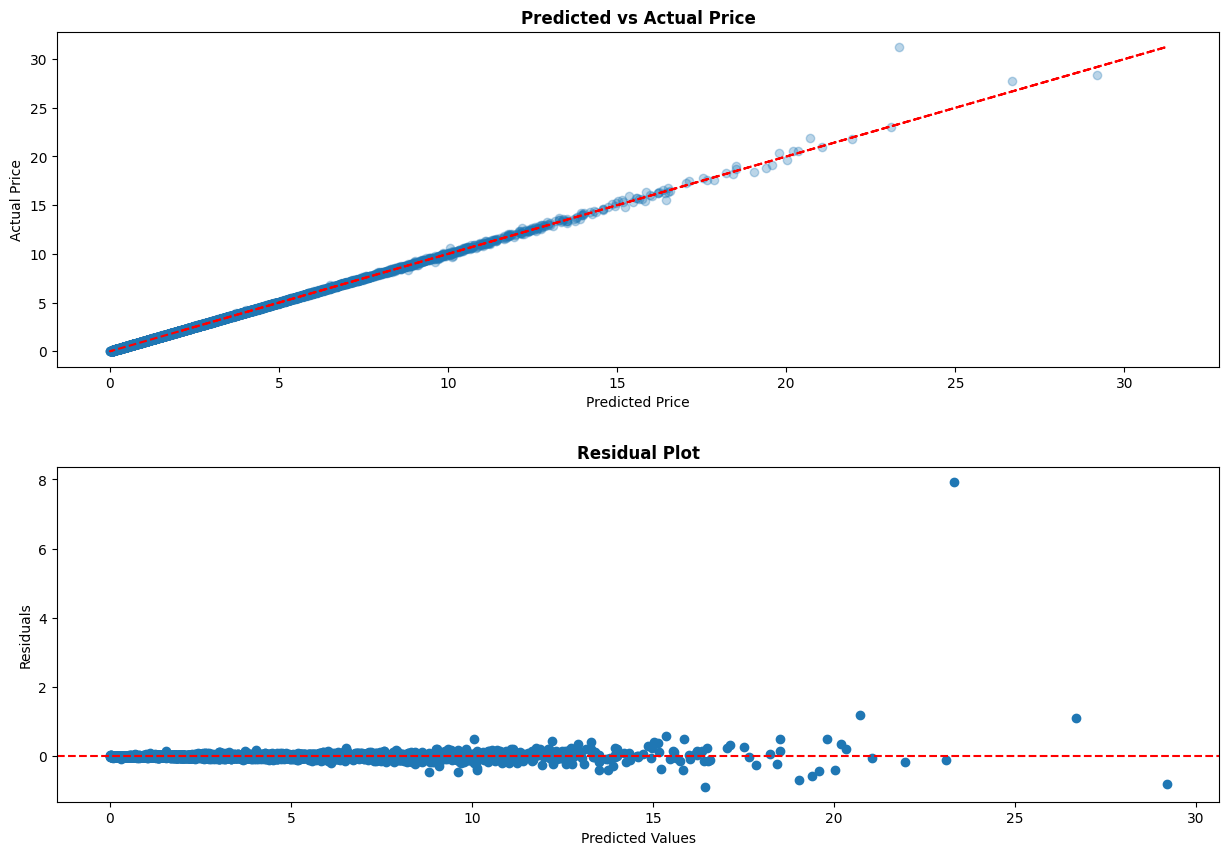

In [18]:
# create dataframe for residual analysis
df_xgb_tuned = pd.DataFrame({'act':dfTest[target],
                            'pred':y_pred
                        })

df_xgb_tuned['diff'] = df_xgb_tuned['act']-df_xgb_tuned['pred']

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot actual vs predicted price
ax1.scatter(df_xgb_tuned['pred'], df_xgb_tuned['act'], alpha=0.3)
ax1.plot(df_xgb_tuned['act'], df_xgb_tuned['act'], color='r', alpha=1, linestyle='--')
ax1.set_title('Predicted vs Actual Price', fontweight='bold')
ax1.set_xlabel('Predicted Price')
ax1.set_ylabel('Actual Price')

# Plot residual plot
ax2.scatter(df_xgb_tuned['pred'], df_xgb_tuned['diff'])
ax2.axhline(y=0, color='r', linestyle='--')
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Residuals')
ax2.set_title('Residual Plot', fontweight='bold')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.3)

# Display the plot
plt.show()

2. Explanation

XGboost belongs to low-interpretability models due to its high-complexity. So, to generate insight on how models that we have make works we can use explanation. An explanation is the answer to a why-question. In this part, we will use SHAP method. SHAP (SHapley Additive exPlanations) by Lundberg and Lee (2017) is a method to explain individual predictions. SHAP is based on the game theoretically optimal Shapley values.

Reference: [christophm](https://christophm.github.io/interpretable-ml-book/explanation.html#explanation)

 99%|===================| 13840/14000 [01:24<00:00]        

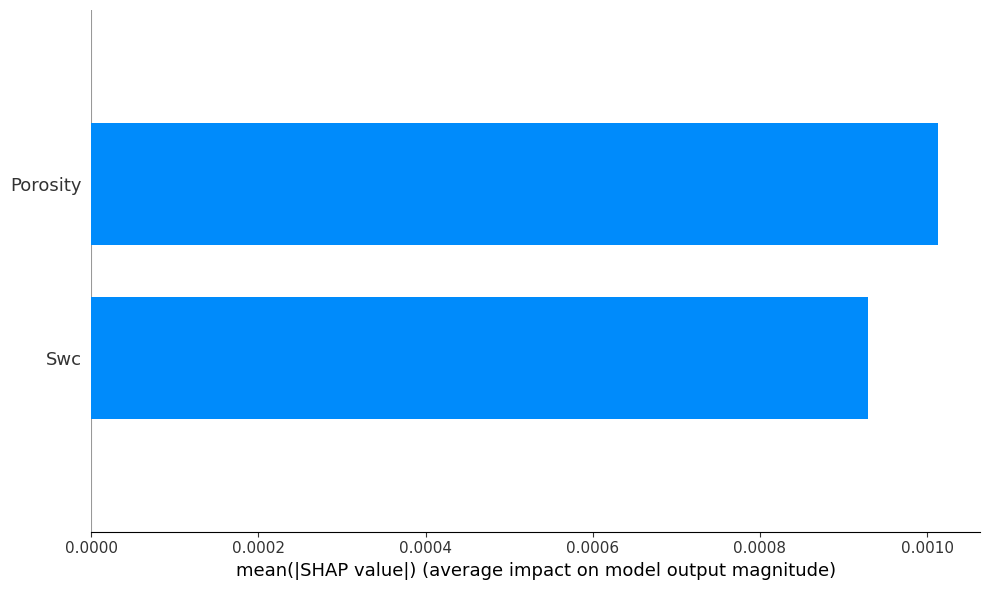

In [21]:
import shap

# model explanation using shap value
explainer = shap.TreeExplainer(xgb_tuning[-1].fit(dfTrain, np.log(dfTrain[target])), data=dfTest)
shap_values = explainer.shap_values(X = dfTest[feature], y=dfTest[target], check_additivity=False)

# shap feature importance plot
shap.summary_plot(shap_values, dfTest[feature], plot_type='bar', plot_size=[10,6])

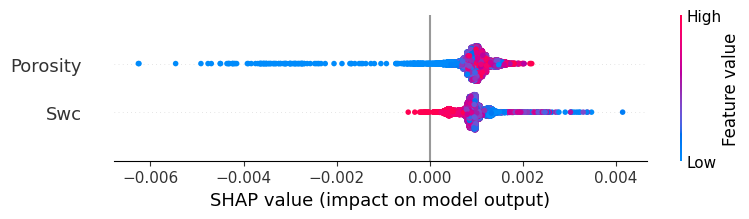

In [22]:
# Plot summary_plot
shap.summary_plot(shap_values, dfTest[feature])

<h3><span style="color:#0ad0f7">Save Final Model</span></h3>

In [14]:
# save model
import pickle
pickle.dump(xgb_tuning, open('../model/permeability_prediction.sav', 'wb'))

In [15]:
# Load model
# filename = '../model/permeability_prediction.sav'
# loaded_model = pickle.load(open(filename, 'rb'))
# print('MAE test data')
# print(mean_absolute_error(y_true=dfTest[target], y_pred=loaded_model.predict(dfTest[feature])))

MAE test data
0.01848425426421365


-------
-------